###Pydantic BaseModel and data validation

In [1]:
import os
from pathlib import Path
from typing import TypedDict

from IPython.core.display import Image
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition

from lib import displayAllMessages, getAIMessage, cliBot
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from pydantic.v1 import BaseModel, validator

env_path = Path('../sample.env')
load_dotenv(override=True, dotenv_path=env_path)
model = os.getenv("GPT_MODEL")

print(model)


gpt-4o-mini


In [2]:
memory = MemorySaver()
memory_config = {"configurable": {"thread_id": "1"}}
class DefaultState(MessagesState):
    pass

In [3]:
llm = ChatOpenAI(model=model)
tools_list = []
llm_with_tools = llm.bind_tools(tools_list)


def assistantBot(state: DefaultState) -> DefaultState:
   return {"messages":[llm_with_tools.invoke (state['messages'])]}


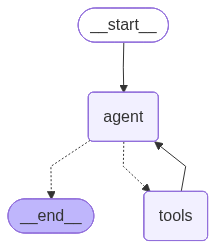

In [4]:
from langgraph.constants import START

g = StateGraph(DefaultState)
g.add_node("agent", assistantBot)
g.add_node("tools", ToolNode(tools_list))

g.add_edge(START, "agent")
g.add_conditional_edges("agent", tools_condition)
g.add_edge("tools", "agent")

graph = g.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

Different input and output state example

    Input and output state can be differnt

In [7]:
cliBot(graphInstance= graph, config= memory_config)


Question:
 explain tata
Assistant:

The term "Tata" can refer to several different entities, depending on the context. Here are a few prominent meanings:

1. **Tata Group**: This is one of India's largest and oldest conglomerates, founded in 1868 by Jamsetji Tata. The Tata Group operates in a wide range of industries including steel, automobiles, consumer products, information technology, and hospitality. Some of its well-known companies include Tata Steel, Tata Motors, Tata Consultancy Services (TCS), and Tata Power.

2. **Tata Motors**: A subsidiary of the Tata Group, Tata Motors specializes in manufacturing automobiles. It is known for producing a wide range of vehicles including cars, trucks, buses, and military vehicles. Tata Motors is also recognized for introducing the Tata Nano, which was aimed to be the world's cheapest car.

3. **Tata Consultancy Services (TCS)**: Another subsidiary of the Tata Group, TCS is a leading global IT services, consulting, and business solutions org

In [6]:
l = ["1", 2, 3, 4]
print(l[-1:])

[4]
